## Tarefa (a) - Geração de Sequências de Bits

In [28]:
import numpy as np

# Geração de quatro sequências de bits pseudo aleatórias
np.random.seed(0)  # Garante a repetibilidade
bit_sequences = [np.random.randint(0, 2, 10000) for _ in range(4)]

In [29]:
print('3 primeiros símbolos (bits) de cada sinal:')
for i in range(4):
    print(f'S_{i}:{bit_sequences[i][:3]}')

3 primeiros símbolos (bits) de cada sinal:
S_0:[0 1 1]
S_1:[1 1 1]
S_2:[0 0 1]
S_3:[1 1 0]


## Tarefa (b) - Ilustração da Técnica FDM

Geramos 4 sinais 2-PAM com pulso retangular de energia unitária.

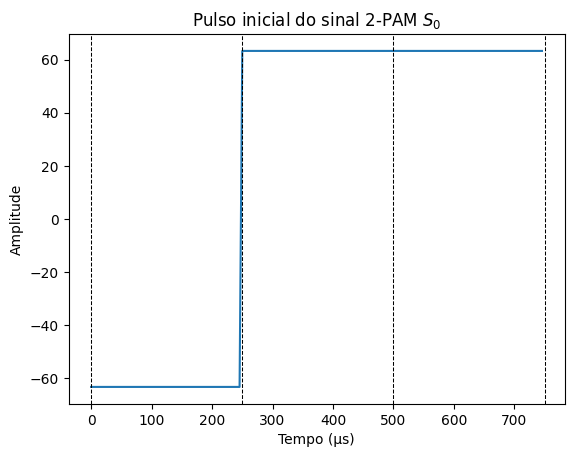

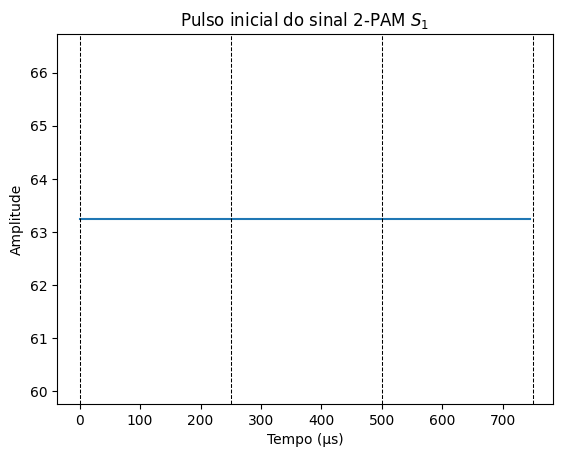

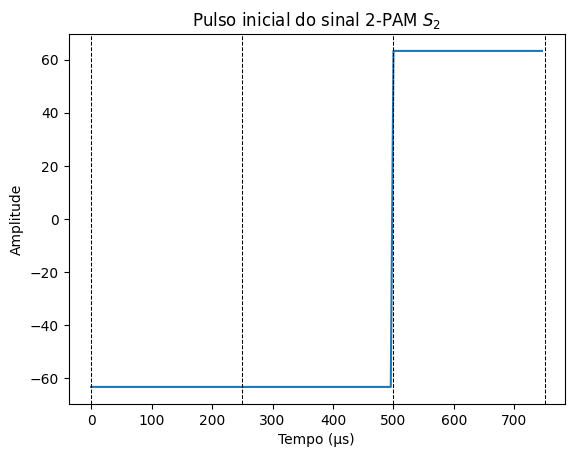

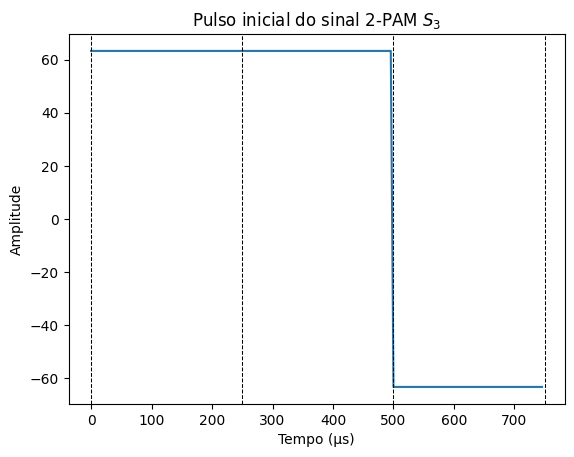

In [30]:
import matplotlib.pyplot as plt

def generate_2PAM_sequence(bits, Ts, Fa):
    """Gera um sinal 2-PAM a partir de uma sequência de bits."""
    t = np.arange(0, len(bits)*Ts, 1/Fa)
    sinal = np.array([1 if bit else -1 for bit in bits])
    sinal = np.repeat(sinal, Fa*Ts)
    return t[:len(sinal)], sinal*Ts**(-0.5)

Ts = 1/4000  # Largura do pulso
Fa = 224000  # Frequência de amostragem

modulated_signals = []

for i, bits in enumerate(bit_sequences):
    t, sinal = generate_2PAM_sequence(bits, Ts, Fa)
    modulated_signals.append(sinal)
    # Plot dos 3 primeiros símbolos
    plt.plot(1e6 * t[:int(3*Fa*Ts)], sinal[:int(3*Fa*Ts)])
    # Adiciona linhas verticais para separar os símbolos
    for j in range(4):  
        plt.axvline(j * Ts * 1e6, color='k', linestyle='--', linewidth=0.75)  
    plt.xlabel('Tempo (μs)')
    plt.ylabel('Amplitude')
    plt.title(f'Pulso inicial do sinal 2-PAM $S_{i}$')
    plt.show()


## Tarefa (c) - Geração do Sinal Multiplexado na Frequência
## Tarefa (d) - Visualização no Domínio do Tempo

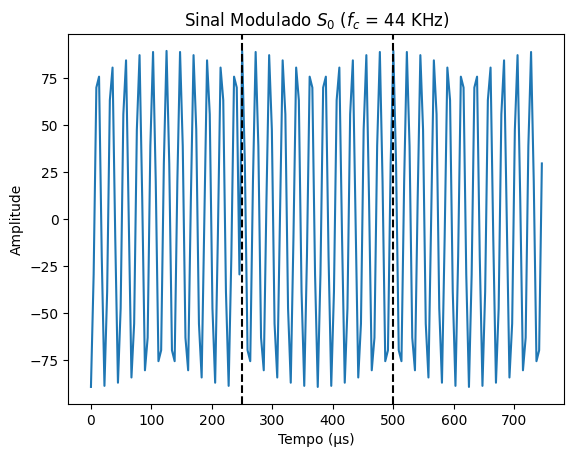

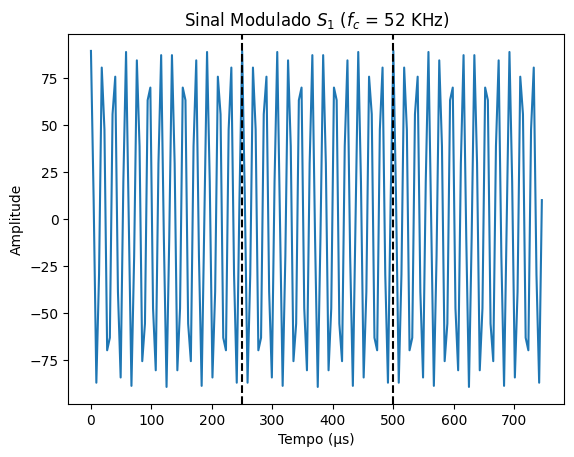

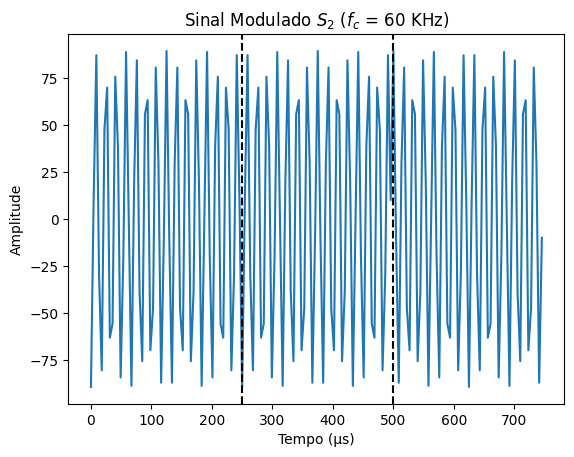

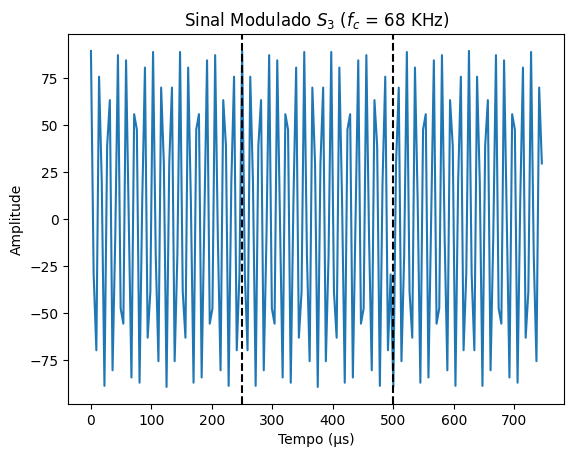

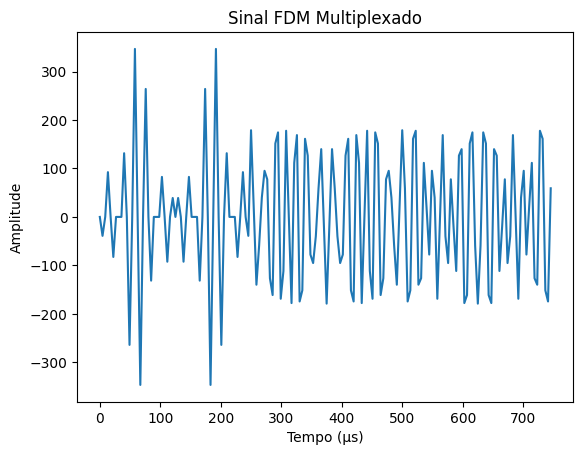

In [31]:
def modulate_signal(signal, fc, t):
    """Modula um sinal com uma portadora de frequência fc - 2-PAM em banda passante."""
    return signal * np.cos(2 * np.pi * fc * t) * np.sqrt(2)

fc_values = [44000, 52000, 60000, 68000]
multiplexed_fdm_signal = np.zeros_like(modulated_signals[0], dtype=float)

for i, (signal, fc) in enumerate(zip(modulated_signals, fc_values)):
    modulated_signal = modulate_signal(signal, fc, t)
    multiplexed_fdm_signal += modulated_signal

    # Plot do sinal modulado individualmente
    plt.plot(1e6 * t[:int(3*Fa*Ts)], modulated_signal[:int(3*Fa*Ts)])
    plt.axvline(Ts * 1e6, color='k', linestyle='--')
    plt.axvline(2 * Ts * 1e6, color='k', linestyle='--')
    plt.xlabel('Tempo (μs)')
    plt.ylabel('Amplitude')
    plt.title(f'Sinal Modulado $S_{i}$ ($f_c$ = {int(fc/1e3)} KHz)')
    plt.show()

# Plot do sinal multiplexado FDM
plt.plot(1e6 * t[:int(3*Fa*Ts)], multiplexed_fdm_signal[:int(3*Fa*Ts)])
plt.xlabel('Tempo (μs)')
plt.ylabel('Amplitude')
plt.title('Sinal FDM Multiplexado')
plt.show()

## Tarefa (e) - Densidade Espectral de Potência

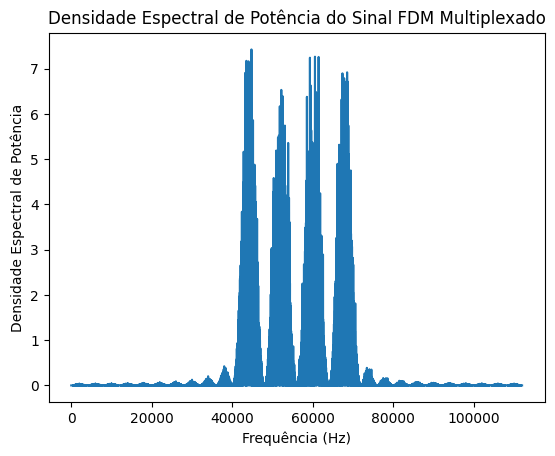

In [64]:
from scipy.signal import periodogram

f, Pxx = periodogram(multiplexed_fdm_signal, Fa)
plt.plot(f, Pxx)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade Espectral de Potência')
plt.title('Densidade Espectral de Potência do Sinal FDM Multiplexado')
plt.show()


## Tarefa (f) - Ilustração da Técnica TDM

In [33]:
# O pulso para TDM deve ser 4 vezes menor que o de FDM
Ts_tdm = Ts / 4
tdm_signals = []
for bits in bit_sequences:
    t, sinal = generate_2PAM_sequence(bits, Ts_tdm, Fa)
    tdm_signals.append(sinal)
n = len(tdm_signals)  # Número de sinais
# quantas amostras de cada sinal cabem em um intervalo de tempo Ts_tdm
m = int(Fa * Ts_tdm)

# Cria um array para cada sinal que inclua os intervalos "desligados"
tdm_signal_arrays = []
for i in range(n):
    # Inicializa com zeros (sinal "desligado")
    tdm_array = np.zeros(len(tdm_signals[0]) * n)
   
    # Preenche o array com o sinal "ligado" em seu intervalo de tempo
    for j in range(len(tdm_signals[i]) // m):
        start_index = j * n * m + i * m
        end_index = start_index + m
        tdm_array[start_index:end_index] = tdm_signals[i][j * m: j * m + m]

    tdm_signal_arrays.append(tdm_array)
t_tdm = np.arange(0, len(tdm_signal_arrays[0]) / Fa, 1 / Fa)


## Tarefa (g) - Geração do Sinal Multiplexado no Tempo para TDM

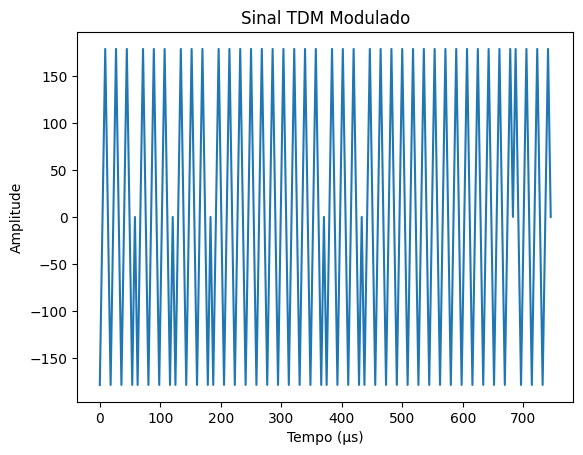

In [34]:
# Definição da frequência da portadora para a modulação
fc = 56000  # 56.000 Hz

# Combinar todos os sinais TDM em um único sinal
combined_tdm_signal = np.sum(tdm_signal_arrays, axis=0)

# Modulação do sinal TDM combinado
modulated_tdm_signal = modulate_signal(combined_tdm_signal, fc, t_tdm)

# Plot do sinal TDM modulado
plt.plot(1e6 * t_tdm[:int(12*Fa*Ts_tdm)], modulated_tdm_signal[:int(12*Fa*Ts_tdm)])
plt.xlabel('Tempo (μs)')
plt.ylabel('Amplitude')
plt.title('Sinal TDM Modulado')
plt.show()


## Tarefa (h) - Visualização no Domínio do Tempo para TDM

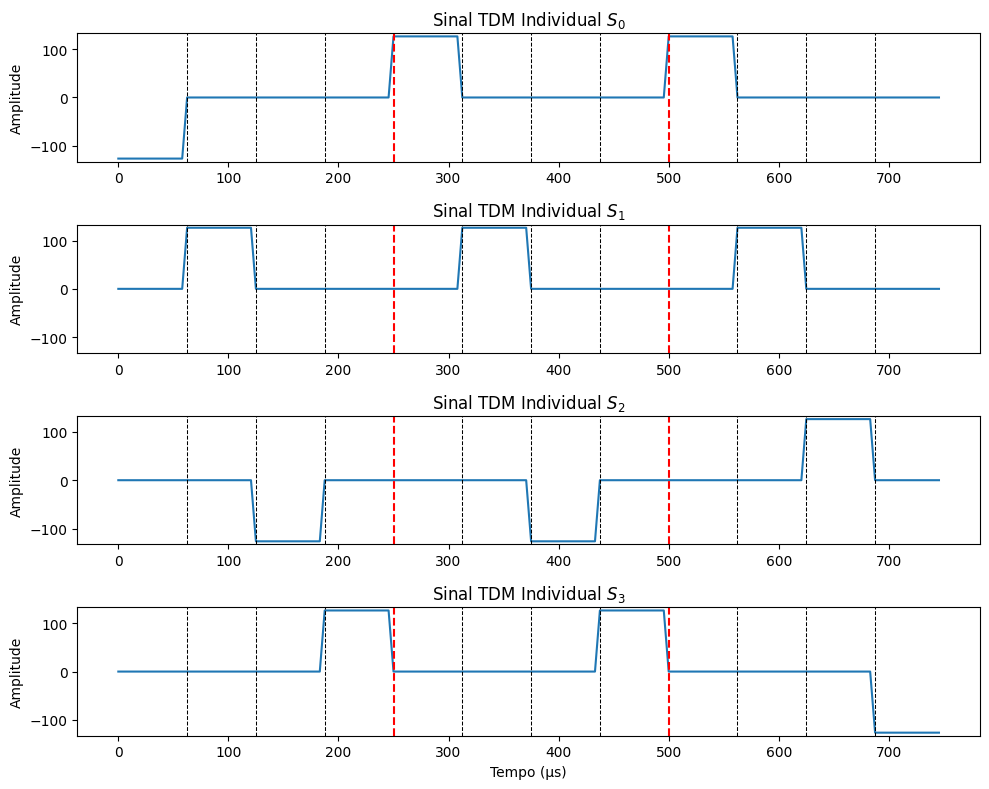

In [35]:
# Definindo o intervalo de tempo para os gráficos
time_interval_tdm = int(12 * Fa * Ts_tdm)
t_tdm_plot = 1e6 * t_tdm[:time_interval_tdm]  # Tempo em microssegundos

# Criar uma figura com 4 subplots (ou o número de sinais TDM que você tem)
fig, axs = plt.subplots(len(tdm_signal_arrays), 1, figsize=(10, 8))


# Plotar cada sinal TDM em um subplot separado
for i, tdm_array in enumerate(tdm_signal_arrays):
    max_y = np.max(np.abs(tdm_array[:time_interval_tdm]))
    axs[i].plot(t_tdm_plot, tdm_array[:time_interval_tdm])
    axs[i].axvline(Ts * 1e6, color='r', linestyle='--')
    axs[i].axvline(2 * Ts * 1e6, color='r', linestyle='--')
    for j in range(12):
        if j % 4 != 0:
            axs[i].axvline(j * Ts_tdm * 1e6, color='k', linestyle='--', linewidth=0.75)
    axs[i].set_ylim([-1.05 * max_y, 1.05 * max_y])
    axs[i].set_ylabel('Amplitude')
    axs[i].set_title(f'Sinal TDM Individual $S_{i}$')

# Ajustar o layout
axs[-1].set_xlabel('Tempo (μs)')
plt.tight_layout()
plt.show()

# Colocavr em banda passante dps

## Tarefa (i) - Densidade Espectral de Potência para TDM

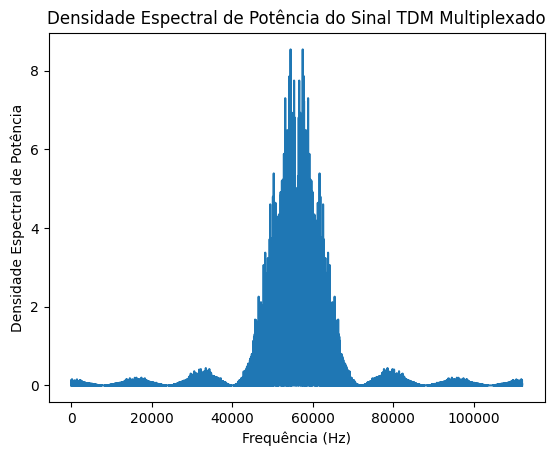

In [65]:
f_tdm, Pxx_tdm = periodogram(modulated_tdm_signal, Fa)
plt.plot(f_tdm, Pxx_tdm)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade Espectral de Potência')
plt.title('Densidade Espectral de Potência do Sinal TDM Multiplexado')
plt.show()

## Tarefa (j) - Ilustração da Técnica CDM

In [37]:
# Sequências de espalhamento
spreading_sequences = np.array([[0, 0, 1, 1, 1, 0, 1],
                                [0, 1, 1, 1, 0, 1, 0],
                                [1, 1, 1, 0, 1, 0, 0],
                                [1, 1, 0, 1, 0, 0, 1]])

# Ajustar e repetir as sequências para igualar o tamanho das sequências de bits
spread_sequences = []
bit_sequence_length = len(bit_sequences[0])
for sequence in spreading_sequences:
    repeat_times = bit_sequence_length // len(sequence) + 1  # Garante cobertura total
    repeated_sequence = np.tile(sequence, repeat_times)
    spread_sequences.append(repeated_sequence[:bit_sequence_length])  # Corta para o tamanho correto

cdm_signals = []
for bits, spread_seq in zip(bit_sequences, spread_sequences):
    spread_bits = bits ^ spread_seq
    t, sinal = generate_2PAM_sequence(spread_bits, Ts, Fa)
    cdm_signals.append(sinal)


## Tarefa (k) - Geração do Sinal Multiplexado no Tempo para CDM

In [71]:
# modular os sinais CDM
fc = 56000 # .25 da frequência de amostragem - amostrando só 4 ptos de uma senoide, RUIM
modulated_cdm_signals = []
for signal in cdm_signals:
    modulated_cdm_signal_indiv = modulate_signal(signal, fc, t)
    modulated_cdm_signals.append(modulated_cdm_signal_indiv)

In [72]:
# Combinar todos os sinais CDM em um único sinal
modulated_cdm_signal = np.sum(modulated_cdm_signals, axis=0)#modulate_signal(combined_cdm_signal, fc, t)

## Tarefa (l) - Visualização no Domínio do Tempo para CDM

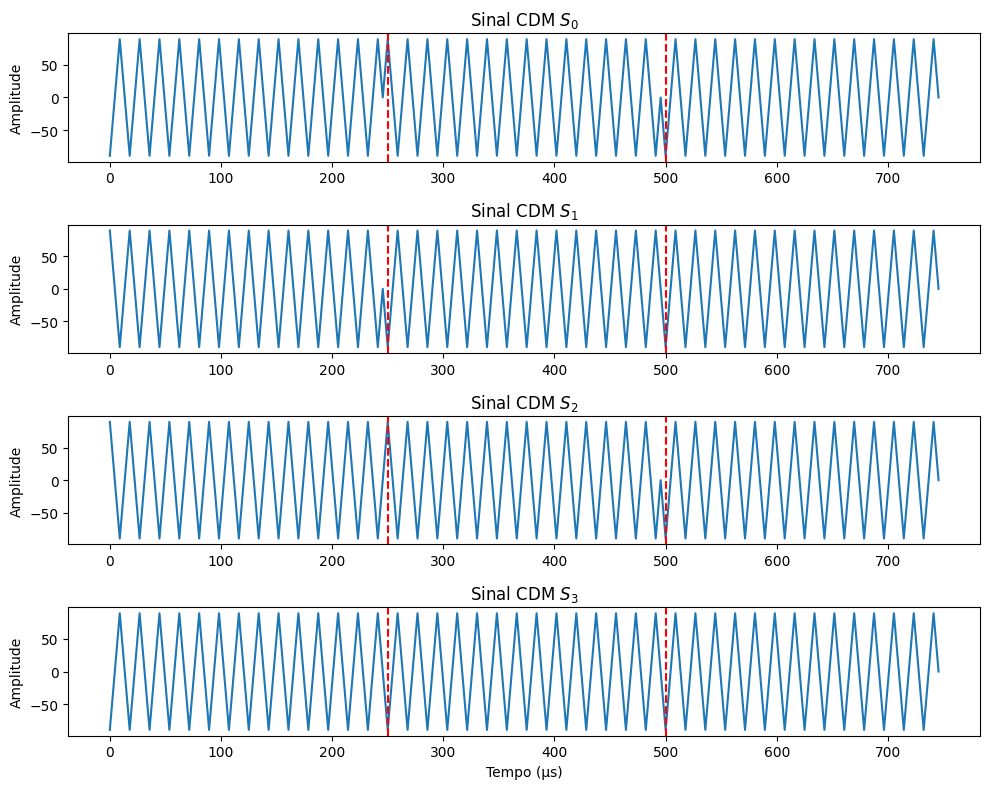

In [73]:
# Definindo o intervalo de tempo para os três primeiros símbolos
time_interval = int(3 * Fa * Ts)
t_plot = 1e6 * t[:time_interval]  # Tempo em microssegundos

# Criar uma figura com 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# Plotar cada sinal CDM em um subplot separado
for i in range(4):
    axs[i].plot(1e6 * t[:int(3*Fa*Ts)], modulated_cdm_signals[i][:time_interval])
    axs[i].axvline(Ts * 1e6, color='r', linestyle='--')
    axs[i].axvline(2 * Ts * 1e6, color='r', linestyle='--')
    axs[i].set_title(f'Sinal CDM $S_{i}$')
    axs[i].set_ylabel('Amplitude')

# Ajustar o layout
plt.xlabel('Tempo (μs)')
plt.tight_layout()
plt.show()


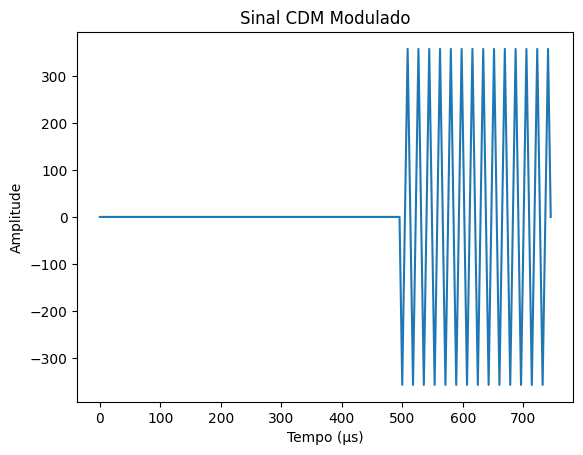

In [77]:
# Plot do sinal CDM modulado
plt.plot(1e6 * t[:int(3*Fa*Ts)], modulated_cdm_signal[:int(3*Fa*Ts)])
plt.xlabel('Tempo (μs)')
plt.ylabel('Amplitude')
plt.title('Sinal CDM Modulado')
plt.show()

## Tarefa (m) - Densidade Espectral de Potência para CDM

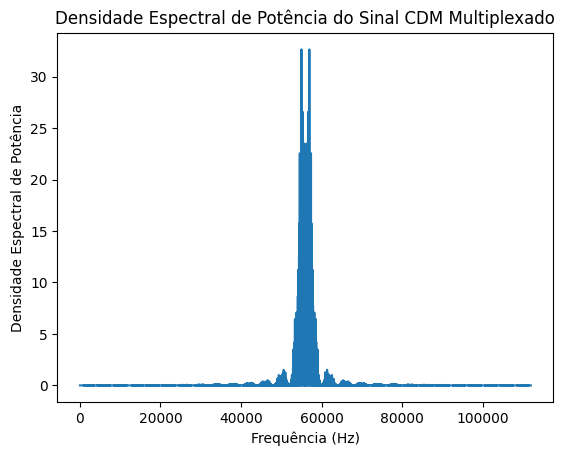

In [75]:
f_cdm, Pxx_cdm = periodogram(modulated_cdm_signal, Fa)
plt.plot(f_cdm, Pxx_cdm)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade Espectral de Potência')
plt.title('Densidade Espectral de Potência do Sinal CDM Multiplexado')
plt.show()

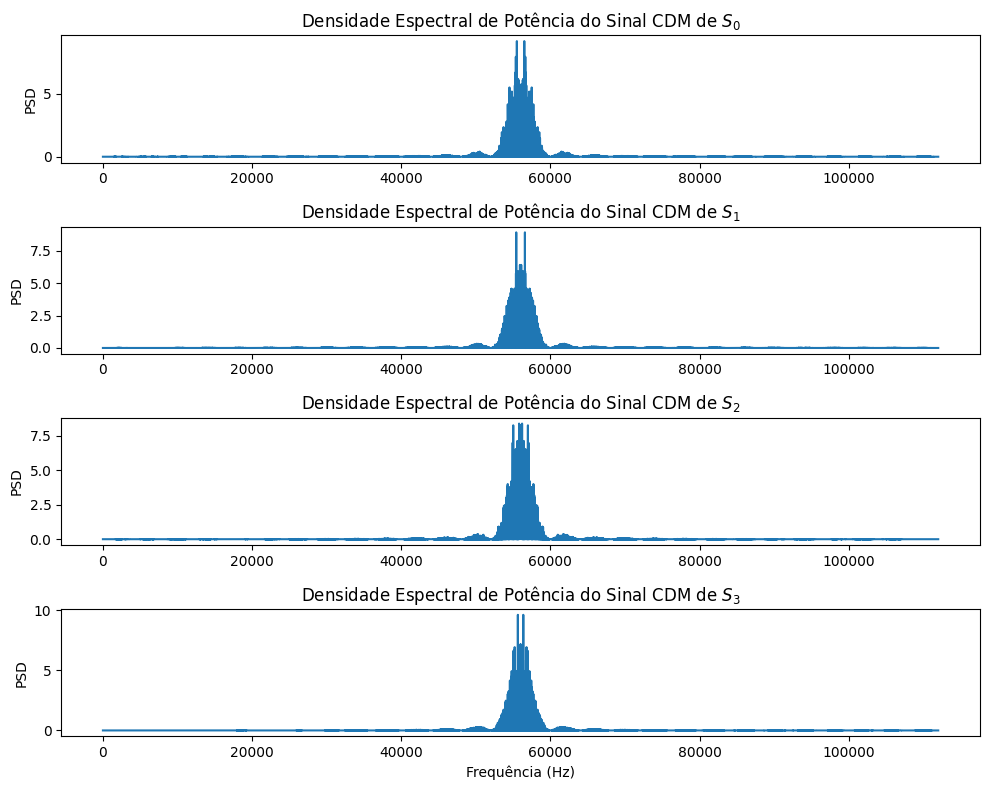

In [76]:
# Criar uma figura com 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

for i, signal in enumerate(modulated_cdm_signals):
    f_cdm, Pxx_cdm = periodogram(modulated_cdm_signals[i], Fa)
    
    axs[i].plot(f_cdm, Pxx_cdm)
    axs[i].set_title(f'Densidade Espectral de Potência do Sinal CDM de $S_{i}$')
    axs[i].set_ylabel('PSD')

axs[-1].set_xlabel('Frequência (Hz)')
plt.tight_layout()
plt.show()

## Tarefa (n) - Experimento com Sequências de Espalhamento

### Tabela XOR

| XOR | 0 | 1 |
|-----|---|---|
| 0   | 0 | 1 |
| 1   | 1 | 0 |

### Tabela MULTIPLICAÇÃO 2-PAM


| PAM | 0 | 1 |
|-----|---|---|
| 0   | 1 | 0 |
| 1   | 0 | 1 |

$$f(x) = \begin{cases}
-1, & \text{se } x = 0 \\
+1, & \text{se } x = 1
\end{cases}$$

Conceitualmente, a operação de multiplicação 2-PAM é equivalente à operação de NOT XOR. Ou seja, se temos duas sequências binárias (i.e. de valores $v \in \{0, 1\}$) $x[k]$ e $y[k]$, podemos representá-las como sinais 2-PAM $x_p[k]$ e $y_p[k]$ da seguinte forma:

$$x_p[k] = f(x[k]) \quad \text{e} \quad y_p[k] = f(y[k])$$

multiplicando-as, obtemos $z_p[k] = x_p[k] \cdot y_p[k]$.

Vejamos a tabela de multiplicação:

| MUL | -1 | +1 |
|-----|----|----|
| -1  | +1 | -1 |
| +1  | -1 | +1 |

agora, para voltar para o domínio binário, basta aplicar a função $f^{-1}(x)$. Perceba que primeiro devemos inverter o sinal, e depois aplicar a função $f^{-1}(x)$, de tal forma que:

$$z[k] = f^{-1}(-z_p[k])$$

Ou seja:

$$x[k] \oplus y[k] = f^{-1}(-x_p[k] \cdot y_p[k])$$

Ou, equivalentemente:

$$x_p[k] \cdot y_p[k] = -f(x[k] \oplus y[k])$$

Assim, como o CDM envolve uma operação de XOR, podemos esperar que a etapa de desespalhamento, a qual envolve uma operação de multiplicação 2-PAM, modifique apenas a fase do sinal, mas não sua amplitude, no espectro de frequências:

$$\mathcal{F}\{-x[k]\} = -\mathcal{F}\{x[k]\}$$

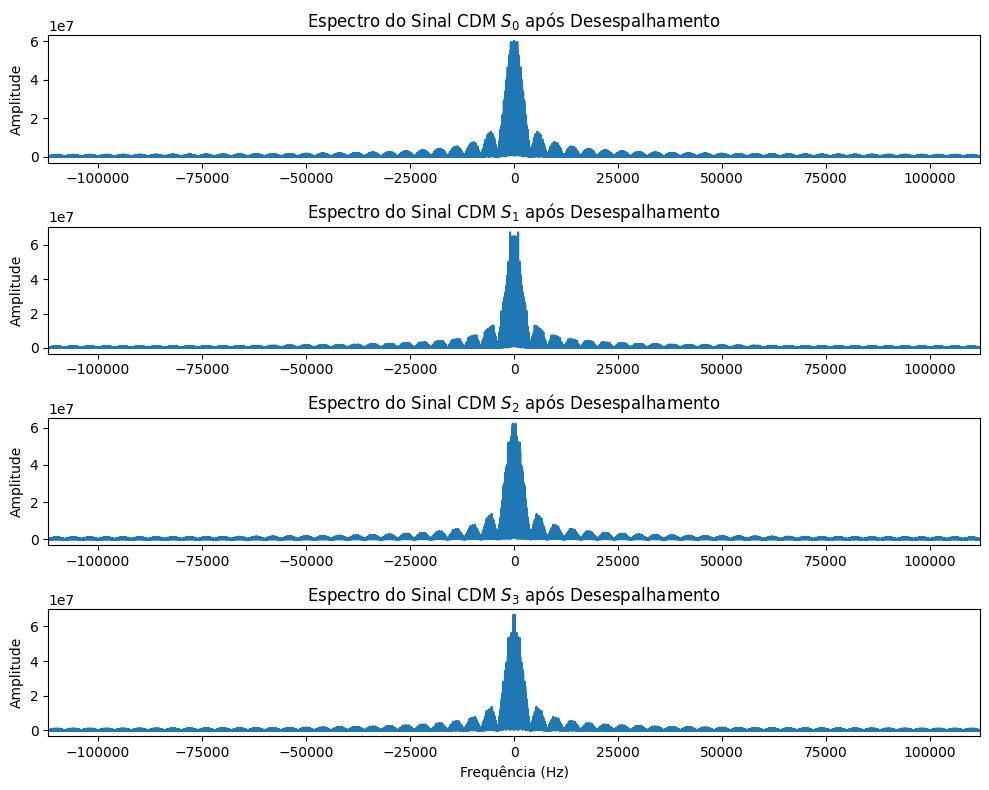

In [43]:
from scipy.fft import fft, fftshift

# Escolhendo uma das sequências de espalhamento (por exemplo, a primeira)
selected_spread_sequence = spread_sequences[0]

# Preparando a sequência de espalhamento para multiplicação
_, spread_signal = generate_2PAM_sequence(selected_spread_sequence, Ts, Fa)

# Multiplicando cada sinal CDM pela sequência de espalhamento escolhida
despread_signals = [s * spread_signal for s in cdm_signals]

# Visualização no domínio da frequência
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

for i, signal in enumerate(despread_signals):
    # Calculando a FFT do sinal
    yf = fft(signal)
    xf = fftshift(np.fft.fftfreq(len(signal), 1/Fa))

    axs[i].plot(xf, np.abs(fftshift(yf)))
    axs[i].set_title(f'Espectro do Sinal CDM $S_{i}$ após Desespalhamento')
    axs[i].set_ylabel('Amplitude')
    axs[i].set_xlim([-Fa/2, Fa/2])  # Limitando o eixo x para mostrar o espectro relevante

axs[-1].set_xlabel('Frequência (Hz)')
plt.tight_layout()
plt.show()


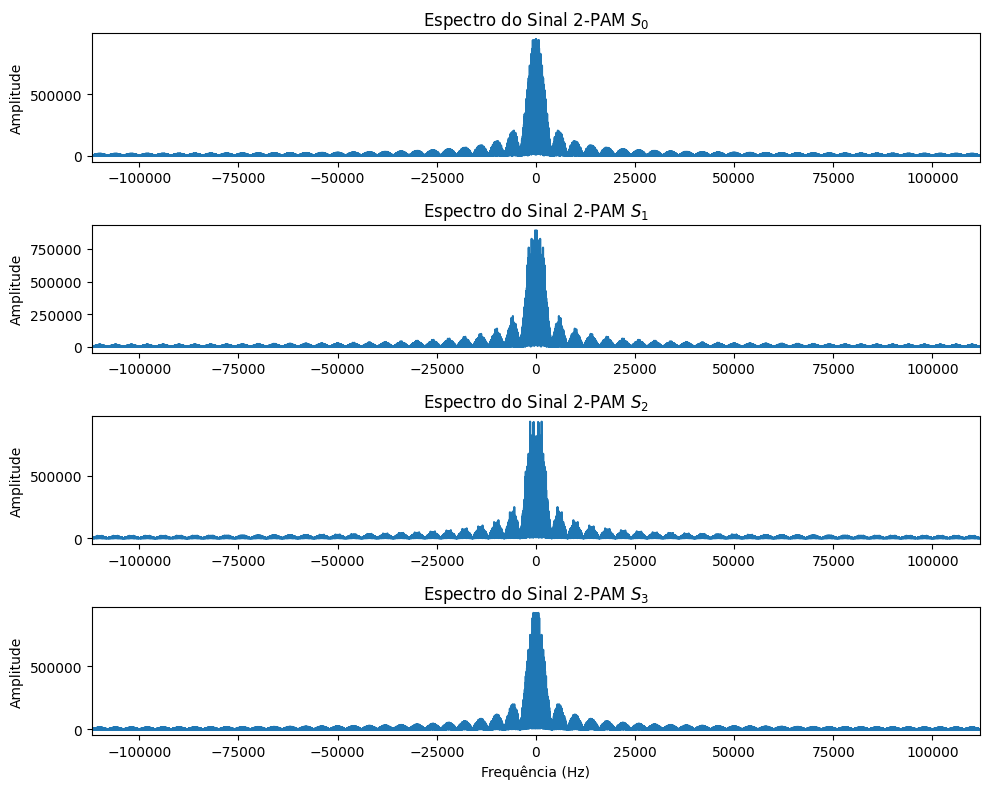

In [44]:
# Visualização no domínio da frequência
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

for i, signal in enumerate(modulated_signals):
    # Calculando a FFT do sinal
    yf = fft(signal)
    xf = fftshift(np.fft.fftfreq(len(signal), 1/Fa))

    axs[i].plot(xf, np.abs(fftshift(yf)))
    axs[i].set_title(f'Espectro do Sinal 2-PAM $S_{i}$')
    axs[i].set_ylabel('Amplitude')
    axs[i].set_xlim([-Fa/2, Fa/2])  # Limitando o eixo x para mostrar o espectro relevante

axs[-1].set_xlabel('Frequência (Hz)')
plt.tight_layout()
plt.show()

In [45]:
# checar se cdm_signals e despread_signals são iguais
for i, (s1, s2) in enumerate(zip(modulated_signals, despread_signals)):
    if not np.allclose(s1, -s2):
        print(f'Os sinais não são iguais para S_{i}')
    else:
        print(f'Os sinais são iguais para S_{i}')

Os sinais não são iguais para S_0
Os sinais não são iguais para S_1
Os sinais não são iguais para S_2
Os sinais não são iguais para S_3
